# Hilbert-Huang Transform (HHT) 解析チュートリアル

このチュートリアルでは、`gwexpy` を用いた Hilbert-Huang Transform (HHT) の実践的な使用方法を解説します。
HHT は非線形・非定常信号の解析に適しており、重力波データ解析（特に CCSN やグリッチ解析など、モデル化が困難なバースト信号）において強力なツールとなります。

## 目次
1. **HHT とは？なぜ重力波解析に使うのか？**
2. **前処理パイプラインの重要性**
3. **合成信号を用いた解析例 (EMD と IMF)**
4. **瞬時周波数 (IF) の計算と平滑化**
5. **Hilbert Spectrum (HHT マップ) の詳細設定**
6. **実践的な解析レシピ (推奨設定)**


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from gwexpy.timeseries import TimeSeries
from astropy import units as u

# PyEMD の確認
try:
    import PyEMD
    print("PyEMD is installed.")
except ImportError:
    print("PyEMD is NOT installed. This tutorial requires PyEMD.")


PyEMD is installed.


## 1. HHT とは？なぜ重力波解析に使うのか？

### STFT / Q-transform との違い
短時間フーリエ変換 (STFT) や Q-transform は、固定された基底関数（正弦波やウェーブレット）との相関を見ますが、HHT はデータ自身から適応的に基底（IMF）を生成します。これにより、急峻な周波数変動や非線形な波形を高精度に捉えることが可能です。

### 基本用語
*   **IMF (Intrinsic Mode Function)**: EMD によって分解された、単一成分に近い振動モード。
*   **Analytic Signal (解析信号)**: ヒルベルト変換を用いて複素数化した信号。$z(t) = a(t) exp(i \phi(t))$。
*   **IA (Instantaneous Amplitude)**: 解析信号の振幅 $a(t)$。
*   **IF (Instantaneous Frequency)**: 解析信号の位相の時間微分 $f(t) = (1/2\pi) d\phi/dt$。

### HHT マップ vs スペクトログラム
HHT の本質的な出力は、時間-周波数平面上の「曲線（軌跡）」です。これを 2D 画像（スペクトログラム）として表示する場合、各ピクセルにエネルギーを「ビン詰め (binning)」する必要があります。したがって、HHT スペクトログラムの見た目はビンの切り方や重み付けに依存することを理解しておく必要があります。


### 理論的背景 (Mathematical Formulation)

**1. Empirical Mode Decomposition (EMD)**
EMD は、信号 $x(t)$ を「固有モード関数 (IMF: Intrinsic Mode Function)」 $c_i(t)$ と「残差 (residual)」 $r_n(t)$ の和に分解する手法です。
$$ x(t) = \sum_{i=1}^{n} c_i(t) + r_n(t) $$
ここで、各 IMF $c_i(t)$ は以下の2条件を満たす必要があります：
1. データ全域で、極値の数とゼロ交差の数が等しいか、その差が1以内である。
2. 任意の位置で、極大値を結ぶ包絡線と極小値を結ぶ包絡線の平均値がゼロである。

**2. Hilbert Transform & Analytic Signal**
抽出された各 IMF $c_i(t)$ に対して、ヒルベルト変換 $H[c_i(t)]$ を計算します。
$$ H[c_i(t)] = \frac{1}{\pi} P \int_{-\infty}^{\infty} \frac{c_i(\tau)}{t-\tau} d\tau $$
これを用いて、複素解析信号 (Analytic Signal) $z_i(t)$ を構成します。
$$ z_i(t) = c_i(t) + j H[c_i(t)] = a_i(t) e^{j \theta_i(t)} $$

**3. Instantaneous Parameters (IA & IF)**
解析信号の極形式から、瞬時振幅 (IA: Instantaneous Amplitude) $a_i(t)$ と 瞬時位相 $\theta_i(t)$ が得られます。
$$ a_i(t) = |z_i(t)| = \sqrt{c_i(t)^2 + H[c_i(t)]^2} $$
$$ \theta_i(t) = \arctan \left( \frac{H[c_i(t)]}{c_i(t)} \right) $$
瞬時周波数 (IF: Instantaneous Frequency) $\omega_i(t)$ は、瞬時位相の時間微分として定義されます。
$$ \omega_i(t) = \frac{d\theta_i(t)}{dt} $$
この $\omega_i(t)$ と $a_i(t)$ を用いて、時間-周波数-エネルギーの分布を描いたものが **Hilbert Spectrum** です。


## 2. 前処理パイプラインの重要性

HHT はデータに適応するため、ノイズやトレンド、端点の影響を強く受けます。以下の前処理を行うことを強く推奨します。

1.  **Detrend / Demean**: 低周波のトレンドや DC オフセットを除去します。これらが残っていると、EMD が低周波成分として抽出しようとして歪みが生じます。
2.  **Whitening (白色化)**: 重力波データは有色雑音を含むため、白色化することで微弱な信号を背景雑音から浮き上がらせます。
3.  **Tapering / Padding**: データの端点は EMD のエンベロープ計算やヒルベルト変換でアーティファクト（端点効果）を生じやすいため、パディング処理が重要です。


## 3. 合成信号を用いた解析例

低周波の正弦波と、高周波のチャープ信号（振幅変調あり）を組み合わせた合成信号を作成し、EMD (Empirical Mode Decomposition) を適用します。


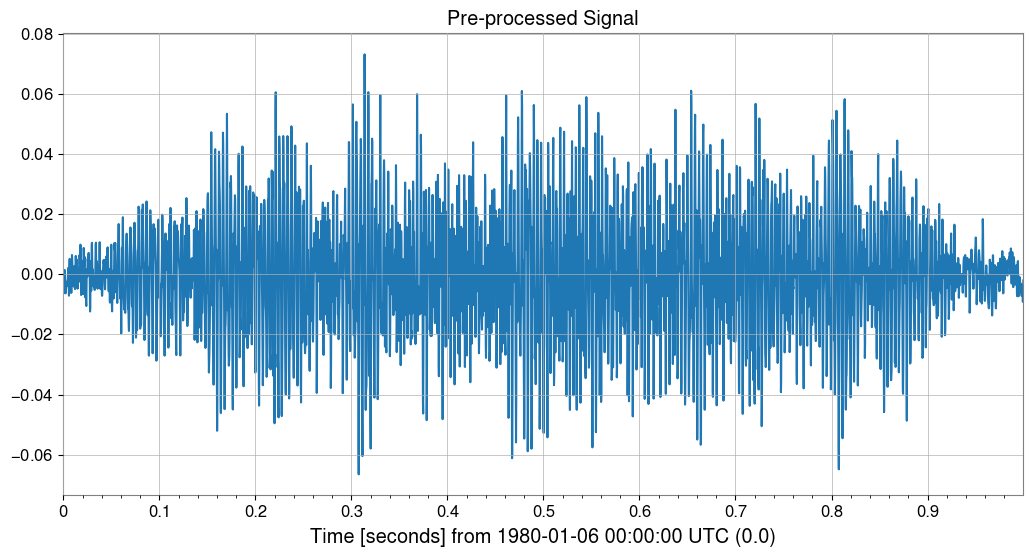

In [11]:
# 合成信号の生成
dt = 1.0 / 4096.0  # 4096 Hz sampling
t = np.arange(0, 1.0, dt)

# 1. 低周波成分 (30 Hz)
low_freq = 0.5 * np.cos(2 * np.pi * 30 * t)

# 2. チャープ成分 (100 Hz -> 400 Hz), 振幅変調あり
f_start, f_end = 100, 400
phase = 2 * np.pi * (f_start * t + 0.5 * (f_end - f_start) * t**2)
chirp = 1.0 * t * np.cos(phase) # 時間とともに振幅増大

# ノイズ
np.random.seed(42)
noise = np.random.normal(0, 0.1, len(t))

data = low_freq + chirp + noise
ts = TimeSeries(data, dt=dt, unit="strain", name="Synthetic_GW")

# 前処理: 白色化とバンドパス (これらをスキップするとEMDの分解能が落ちます)
# fftlength は信号長に合わせて調整
ts_pre = ts.whiten(fftlength=0.5).bandpass(20, 1000)

# プロット
plot = ts_pre.plot(title="Pre-processed Signal")
plot.show()


### EMD による分解

`ts.emd()` を用いて信号を IMF に分解します。重力波データのようなノイズを含む信号には、アンサンブル平均を用いる **EEMD (Ensemble EMD)** が有効です。
`random_state` を指定することで再現性を確保できます。


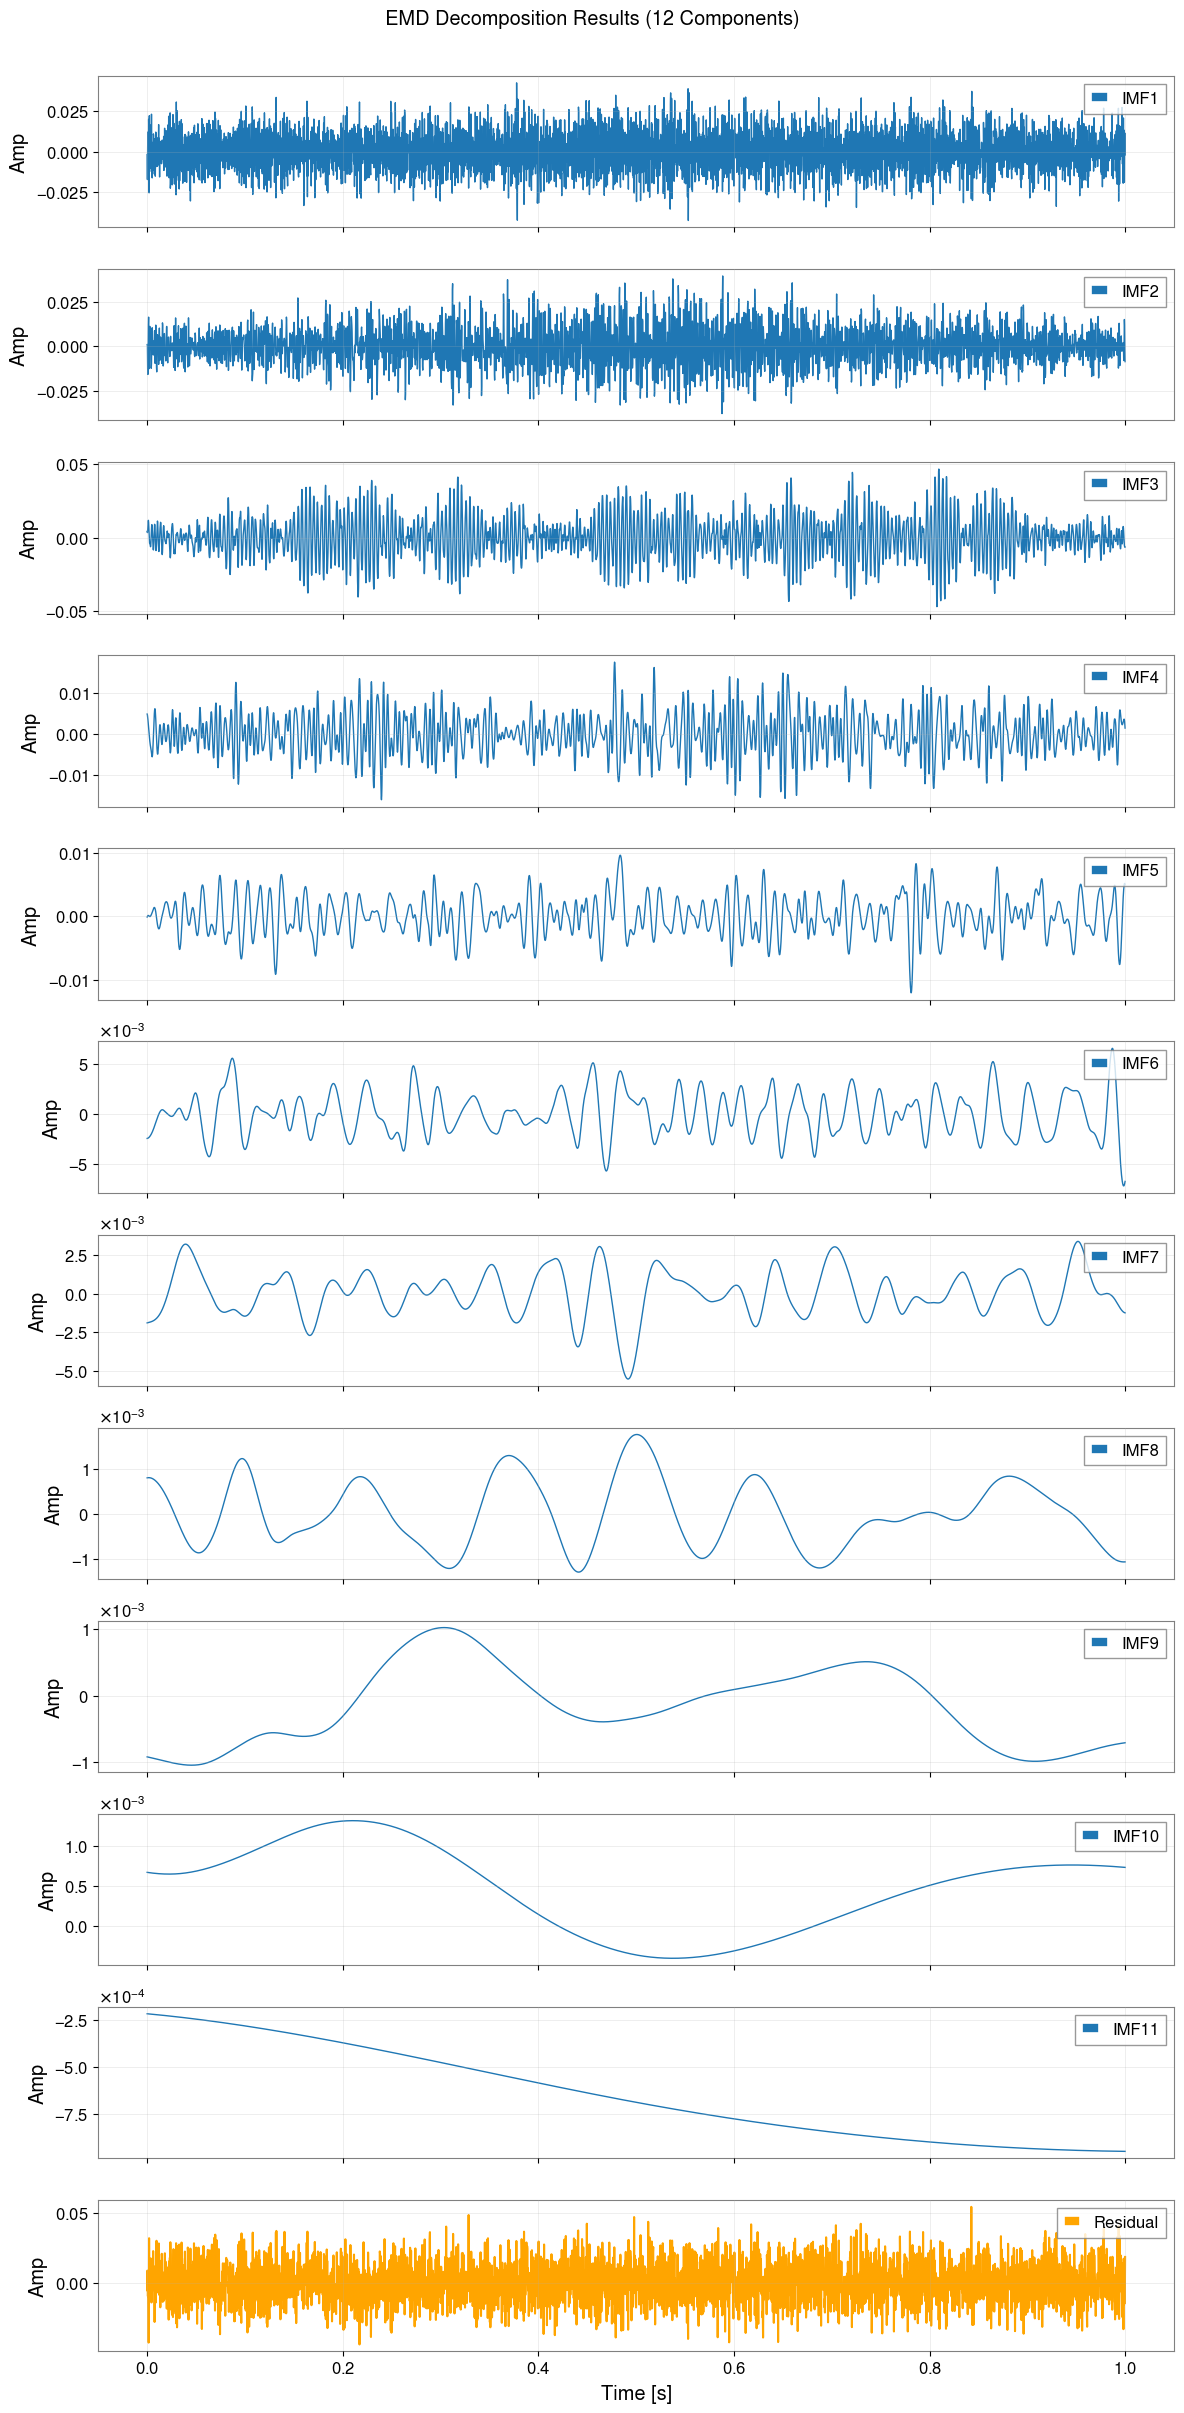

In [12]:
# EMDによる分解の実行
# 重力波のようなノイズ混じりの信号には、モードミキシングを抑制する EEMD が推奨されます。
imfs = ts_pre.emd(method='eemd', eemd_trials=50, random_state=42)


# 全てのIMFと残差(Residual)をプロット
plot_keys = [k for k in imfs.keys() if k.startswith('IMF')]
has_residual = 'residual' in imfs
n_plots = len(plot_keys) + (1 if has_residual else 0)

fig, axes = plt.subplots(n_plots, 1, figsize=(12, 2 * n_plots), sharex=True)
if n_plots == 1: axes = [axes]

# IMFのプロット
for i, key in enumerate(plot_keys):
    ax = axes[i]
    # TimeSeriesオブジェクトなので .times と .value を使用
    ax.plot(imfs[key].times, imfs[key].value, label=key, lw=1)
    ax.legend(loc='upper right')
    ax.set_ylabel('Amp')
    ax.grid(True, alpha=0.3)

# Residualのプロット
if has_residual:
    ax = axes[-1]
    ax.plot(imfs['residual'].times, imfs['residual'].value, label='Residual', color='orange', lw=1.5)
    ax.legend(loc='upper right')
    ax.set_ylabel('Amp')
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel('Time [s]')
plt.suptitle(f"EMD Decomposition Results ({n_plots} Components)", y=1.005)
plt.tight_layout()
plt.show()


### 代表周波数の計算

各 IMF がどのような周波数成分を持っているかを確認するため、エネルギー ($IA^2$) で重み付けした平均周波数を計算します。
**注意**: EMD は周波数順に IMF を出力するとは限りませんが、一般的に IMF1 が最も高周波になります。


In [13]:
# 各IMFの代表周波数を計算
print("Representative Frequencies (Energy-weighted mean IF):")

for key, imf in imfs.items():
    # Hilbert解析
    res = imf.hilbert_analysis()
    
    # NaNを除去するためのマスクを作成
    freq = res["frequency"].value
    amp = res["amplitude"].value
    mask = np.isfinite(freq) & np.isfinite(amp) & (amp > 0)
    
    if np.any(mask):
        # エネルギー重み付け平均
        w_mean_freq = np.average(freq[mask], weights=amp[mask]**2)
        print(f"  {key}: {w_mean_freq:.2f} Hz")
    else:
        print(f"  {key}: -- Hz")


Representative Frequencies (Energy-weighted mean IF):
  IMF1: 1137.72 Hz
  IMF2: 591.57 Hz
  IMF3: 257.80 Hz
  IMF4: 176.62 Hz
  IMF5: 76.80 Hz
  IMF6: 33.19 Hz
  IMF7: 15.64 Hz
  IMF8: 8.13 Hz
  IMF9: 1.86 Hz
  IMF10: 0.88 Hz
  IMF11: 0.50 Hz
  residual: 836.06 Hz


## 4. 瞬時周波数 (IF) の計算と平滑化

ヒルベルト変換から得られる瞬時周波数 (IF) は、数値微分の影響でスパイク状のノイズが乗りやすい性質があります。特に振幅が小さい領域や端点では顕著です。
`hilbert_analysis` の `if_smooth` オプションを使うことで、これを軽減できます。


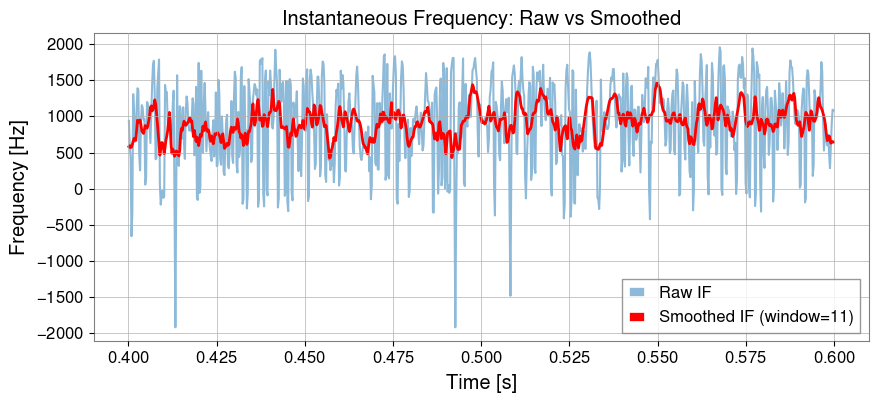

In [14]:
# IMF1 (主要なチャープ成分) を詳しく解析
target_imf = imfs["IMF1"]

# 平滑化なし
res_raw = target_imf.hilbert_analysis(if_smooth=None)

# 平滑化あり (例: 11サンプルの移動平均)
res_smooth = target_imf.hilbert_analysis(if_smooth=11)

# プロット比較
fig, ax = plt.subplots(figsize=(10, 4))
t_vals = target_imf.times.value

# 見やすくするために一部をズーム & 大きなスパイクを除外してプロット
mask = (t_vals > 0.4) & (t_vals < 0.6) # 信号の中央部
ax.plot(t_vals[mask], res_raw["frequency"].value[mask], label="Raw IF", alpha=0.5)
ax.plot(t_vals[mask], res_smooth["frequency"].value[mask], label="Smoothed IF (window=11)", color="red", linewidth=2)

ax.set_ylabel("Frequency [Hz]")
ax.set_xlabel("Time [s]")
ax.set_title("Instantaneous Frequency: Raw vs Smoothed")
ax.legend()
ax.grid(True)
plt.show()


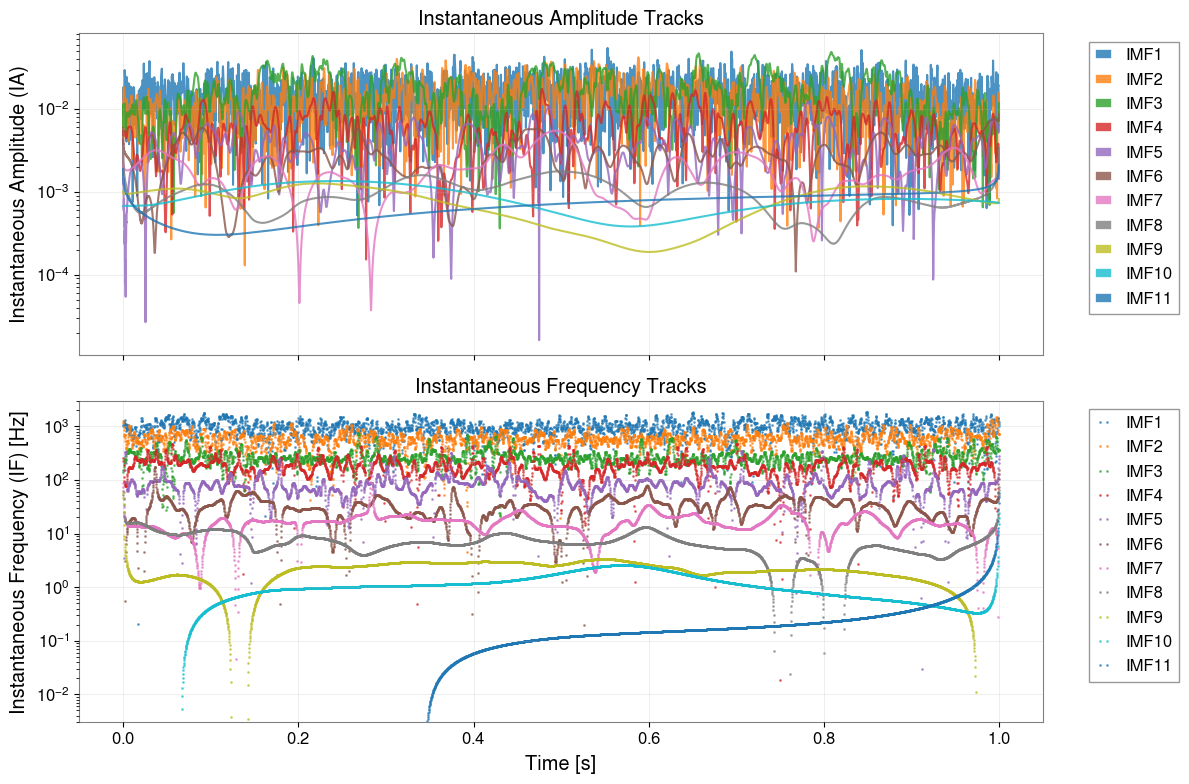

In [15]:
# 全てのIMFに対してヒルベルト解析（IA/IFの計算）を実行
ia_dict = {}
if_dict = {}
plot_keys = [k for k in imfs.keys() if k.startswith('IMF')]

for key in plot_keys:
    # 評価を安定させるため適度に平滑化(if_smooth)を適用することが推奨されます
    res = imfs[key].hilbert_analysis(if_smooth=7)
    ia_dict[key] = res["amplitude"]
    if_dict[key] = res["frequency"]


# 瞬時周波数(IF)と瞬時振幅(IA)のトラック表示
# 上記で計算済みの ia_dict, if_dict を使用します

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# 色のサイクル
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

for i, key in enumerate(plot_keys): # plot_keys defined in previous cell
    color = colors[i % len(colors)]
    
    # IA (Amplitude)
    ax1.plot(ia_dict[key].times, ia_dict[key].value, label=f'{key}', color=color, alpha=0.8)
    
    # IF (Frequency)
    # ノイズ対策のため、振幅が小さいところはプロットしないなどの工夫も可能
    ax2.plot(if_dict[key].times, if_dict[key].value, '.', markersize=2, label=f'{key}', color=color, alpha=0.6)

ax1.set_ylabel('Instantaneous Amplitude (IA)')
ax1.set_yscale('log')
ax1.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
ax1.set_title('Instantaneous Amplitude Tracks')
ax1.grid(True, alpha=0.3)

ax2.set_ylabel('Instantaneous Frequency (IF) [Hz]')
ax2.set_yscale('log')
ax2.set_ylim(0.003, 3000) # 注目したい周波数帯域に制限
ax2.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
ax2.set_title('Instantaneous Frequency Tracks')
ax2.grid(True, alpha=0.3)

plt.xlabel('Time [s]')
plt.tight_layout()
plt.show()


**注意**: 平滑化を行うと時間解像度がわずかに低下します。解析結果を報告する際は、使用した平滑化パラメータを明記することが推奨されます。


## 5. Hilbert Spectrum (HHT マップ) の詳細設定

`ts.hht(output='spectrogram')` を使うことで、HHT の結果をスペクトログラムとして可視化できます。
これは STFT のスペクトログラムとは異なり、計算された IF の軌跡をヒストグラムとして集計したものです。

### オプションによる違い
*   **n_bins / freq_bins**: 周波数分解能を決定します。
*   **weight**: `'ia2'` (エネルギー, デフォルト) または `'ia'` (振幅)。
*   **if_policy**: ビン範囲外の IF の扱い。`'drop'` (捨てる) または `'clip'` (端に寄せる)。
*   **Hilber kwargs**: `pad` オプションで端点効果を抑制できます。


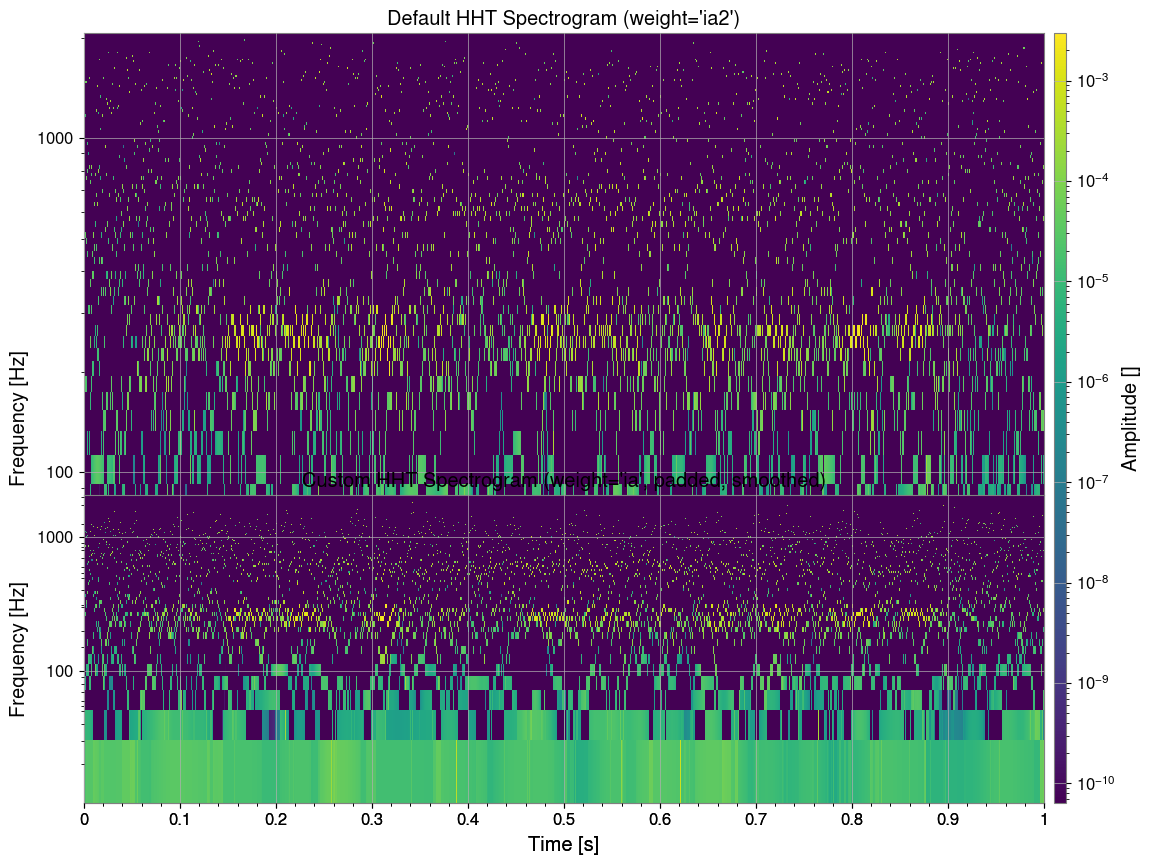

In [16]:
# HHTスペクトログラムを計算
spec_default = ts_pre.hht(output='spectrogram', n_bins=100)
spec_custom = ts_pre.hht(
    output='spectrogram',
    weight='ia',
    n_bins=100,
    hilbert_kwargs={'pad': int(0.1/ts_pre.dt.value), 'if_smooth': 7}
)

# プロット
# HHTSpectrogram.plot() を使用すると、
# 時刻軸(auto-gps)、周波数軸(log)、色軸(log)とラベル、カラーバーが自動的に設定されます。
plot = spec_default.plot(figsize=(12, 10))
ax1 = plot.gca()
ax1.set_title("Default HHT Spectrogram (weight='ia2')")

# 2つ目のサブプロットを追加して別のスペクトログラムを描画
ax2 = plot.add_subplot(2, 1, 2, sharex=ax1)
spec_custom.plot(ax=ax2, colorbar=False)  # カラーバーは1つで十分
ax2.set_title("Custom HHT Spectrogram (weight='ia', padded, smoothed)")

plot.subplots_adjust(hspace=0.5)
plot.show()


## 6. 実践的な解析レシピ (推奨設定)

重力波のようなバースト信号を解析する際の推奨フローと設定例を以下にまとめます。
ここでは汎用的な設定を示しますが、信号の特性（SNRや継続時間）に応じて `eemd_trials` や `if_smooth` を調整してください。


Analyzing Synthetic Chirp GW...


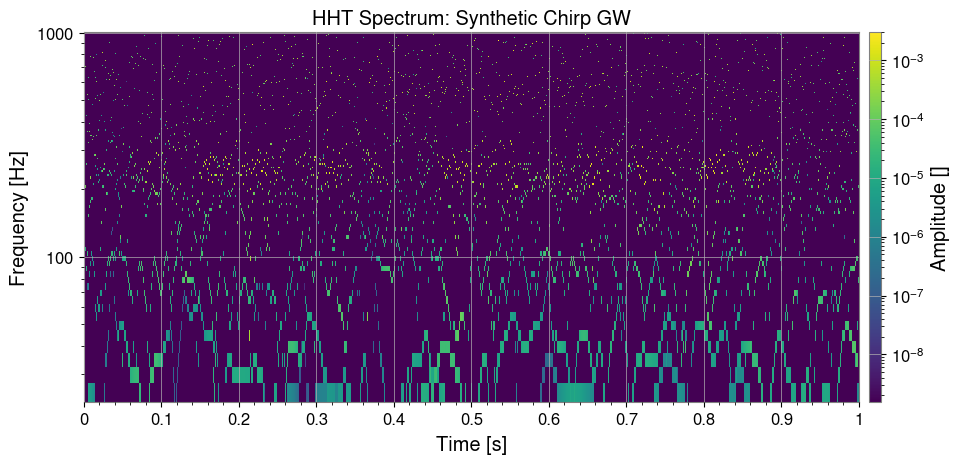

In [17]:
def analyze_burst_signal(timeseries, name="Signal"):
    print(f"Analyzing {name}...")
    
    # 1. 前処理 (白色化 + バンドパス)
    # 実際の解析では、ホワイトニングには十分な長さのデータが必要です。
    # 信号の帯域に合わせてバンドパスフィルタを調整します。
    ts_proc = timeseries.whiten(fftlength=0.5).bandpass(20, 1000)
    
    # 2. 周辺の切り出し (Crop)
    # パディングを使っても端点効果は完全には消えないため、
    # 興味ある領域の前後を少し広めに計算して、最後に表示範囲を絞るのが安全です。
    
    # 3. HHT 変換 (EEMD -> Hilbert)
    spectrum = ts_proc.hht(
        output='spectrogram',
        # EEMD設定: ノイズ耐性を高めるため trials=100 程度推奨
        emd_method='eemd',
        emd_kwargs={'eemd_trials': 50, 'random_state': 42}, 
        
        # Hilbert設定: パディングと平滑化
        # pad: データ長の10%程度または十分な秒数を指定
        # if_smooth: サンプリングレートによるが 5~11 あたり推奨
        hilbert_kwargs={'pad': int(0.1/timeseries.dt.value), 'if_smooth': 7},
        
        # スペクトログラム表示設定
        n_bins=200,          # 周波数分解能
        fmin=20, fmax=1000,  # 表示周波数範囲
        weight='ia2',        # エネルギー表示
        finite_only=True     # NaN等の異常値を除外
    )
    
    # 4. 可視化
    plot = spectrum.plot(figsize=(10, 5))
    ax = plot.gca()
    ax.set_title(f"HHT Spectrum: {name}")
    
    # カラーバーの調整 (対数スケールが見やすい場合がある)
    # plot.colorbar(label=r"Energy ($strain^2$)")
    plot.show()

# 実行例
analyze_burst_signal(ts, name="Synthetic Chirp GW")
